us shape normalize vanda agadi: (400, 64)
us shape normalize vanda pachi: (400, 64)
us shape reshape vanda pachi: (400, 8, 8, 1)
Saving training data to u_train.npy...
Saving grid points to grid.npy...
Saving grid points to grid.npy...
Time to save the data: 0.00 seconds
Data saving completed!
sample data = (8, 8)


C:\Users\Manju\AppData\Local\Temp\ipykernel_19224\3938460916.py:248: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(sample, labels = 10, cmap='viridis')


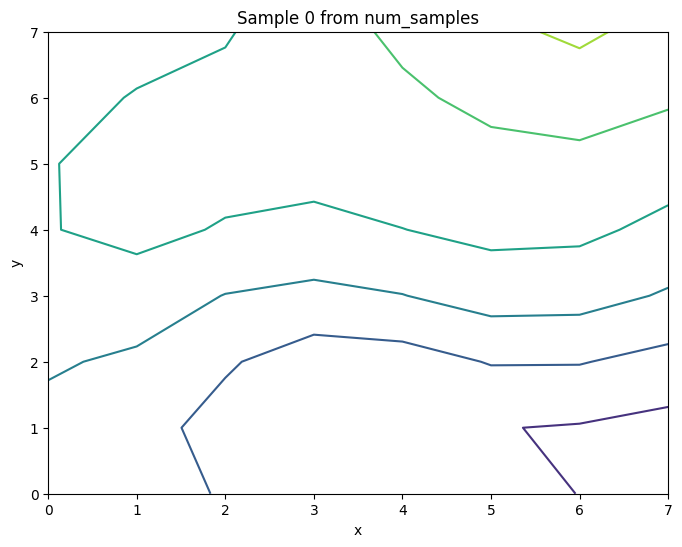

In [1]:
import jax.numpy as jnp
import numpy as np
from jax import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import time





# Exponential quadratic kernel (Gaussian kernel)
def exp_quadratic(X1, X2, length_scale):
    """Compute the exponential quadratic kernel."""
    dists = cdist(X1, X2, metric="sqeuclidean") #dists is distance and cdists is computed distance between two points 
    # print("Distances min:", jnp.min(dists), "max:", jnp.max(dists))
    kernel = jnp.exp(-dists / (2 * length_scale**2)) # aply the kernel function, wich gives the smoothness of te function
    # print("Kernel min:", jnp.min(kernel), "max:", jnp.max(kernel))
    return kernel


# Gaussian process data generator
def gaussian_process_2d(x, n_grid, n_samples, length_scale_list, u_mean=0.0, key=None):
    """
    Generate 2D Gaussian process samples.
    
    Args:
        x: Tuple of domain limits [x1, x2, y1, y2].
        n_grid: Number of grid points in each dimension.
        n_samples: Number of samples to generate.
        length_scale_list: List of length scales for kernel.
        u_mean: Mean value for Gaussian process.
        key: PRNGKey for randomization.

    Returns:
        X: Grid points.
        ys: Samples generated from the Gaussian process.
    """
    x1, x2, y1, y2 = x
    # Create grid
    xx, yy = jnp.meshgrid(
        jnp.linspace(x1, x2, n_grid), jnp.linspace(y1, y2, n_grid)
    )
    grid_points = jnp.stack([xx.ravel(), yy.ravel()], axis=-1)

    if key is None:
        key = random.PRNGKey(42)

    samples = []
    for i in range(n_samples):
        # print(f'generating data {i+1} started out of {n_samples}')
        # Select random length scale
        key, subkey = random.split(key)  # Split the key to ensure randomness
        length_scale = random.choice(subkey, jnp.array(length_scale_list))
        # Compute covariance matrix
        cov = exp_quadratic(grid_points, grid_points, length_scale) # covariance matric is computed, which is used to generate the data, and its gives the relation between the points
        jitter = 1e-5
        cov += jitter * jnp.eye(cov.shape[0])

        # print("Covariance matrix shape:", cov.shape)
        # eigenvalues = jnp.linalg.eigvalsh(cov)
        # # print("After adding jitter:")
        # print("Covariance matrix eigenvalues min:", jnp.min(eigenvalues), "max:", jnp.max(eigenvalues))

        # Generate sample
        sample = random.multivariate_normal(key, u_mean * jnp.ones(grid_points.shape[0]), cov)
        samples.append(sample)
        # print(f'generating data {i+1} done out of {n_samples}')


    return grid_points, jnp.array(samples)


# # Normalize function
# def normalize(data):
#     """Normalize data to the range [-1, 1]."""
#     return 2 * (data - jnp.min(data)) / (jnp.max(data) - jnp.min(data)) - 1


def normalize(data):
    """Normalize data to the range [-1, 1]."""
    min_val = jnp.min(data)
    max_val = jnp.max(data)
    if max_val - min_val == 0:
        return data  # Return unchanged if normalization isn't possible
    return 2 * (data - min_val) / (max_val - min_val) - 1


# Data class
class Data:
    def __init__(self, x, n_grid, length_scale_list, num_samples):
        """
        Initialize data generator.

        Args:
            x: Tuple of domain limits [x1, x2, y1, y2].
            n_grid: Resolution of the grid (number of grid points per dimension).
            length_scale_list: List of length scales for the Gaussian process.
            train_num: Number of training samples to generate.
            test_num: Number of testing samples to generate.
        """
        self.x = x
        self.n_grid = n_grid
        self.length_scale_list = length_scale_list
        self.num_samples = num_samples
        # self.test_num = test_num
        self.__init_data()

    def __init_data(self):
        """Initialize training and testing data."""
        self.X, self.num_samples = self.u_data(self.num_samples)
        # _, self.u_test = self.u_data(self.test_num)

    def u_data(self, n_samples=1):
        """
        Generate Gaussian process data.

        Args:
            n_samples: Number of samples to generate.

        Returns:
            X: Grid points.
            us: Corresponding u(x) values at the grid points.
            us: Corresponding u(x) values at the grid points with 3 channels (RGB).
        """
        # Generate data using Gaussian process
        X, us = gaussian_process_2d(
            self.x, self.n_grid, n_samples, self.length_scale_list
        )

        


        # Normalize and reshape the samples
        us = us - jnp.mean(us, axis=0)  # Subtract mean to introduce variance
        print(f'us shape normalize vanda agadi: {us.shape}')

        us = normalize(us)
        print(f'us shape normalize vanda pachi: {us.shape}')
        us = us.reshape(-1, self.n_grid, self.n_grid, 1)  # Reshape to (n_samples, n_grid, n_grid, 1)
        print(f'us shape reshape vanda pachi: {us.shape}')



        # print(f"Generated {n_samples} samples with shape: {us.shape}")


        # Now create RGB data for each sample, using np.random.rand for each channel
        # Here we create random RGB values for each sample (you can adjust this as needed)
        # us_rgb = np.random.rand(n_samples, self.n_grid, self.n_grid, 1)  # RGB values for color images

        # key = random.PRNGKey(42)  # Initialize PRNG key
        # key, subkey = random.split(key)  # Split key to create subkey


        # You could also modify the us data to contain meaningful RGB values
            # Example: combining some part of 'us' for each channel
        # us_rgb[..., 0] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Red
        # us_rgb[..., 1] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Green
        # us_rgb[..., 2] = normalize(random.normal(subkey, shape=us[..., 0].shape))  # Blue


        return X, us

        # return X, us


# Example Usage
if __name__ == "__main__":
    # Example: Adjust resolution and domain length
    domain = (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi)  
    resolution = 8  # Number of grid points per dimension
    length_scale_list = [0.1, 0.5, 1.0, 2.0]  # Kernel length scales # its indicate the smoothness of the data 
    num_samples = 400 # Number of training samples
    # test_samples = 5  # Number of testing samples

    # Create data object
    data = Data(domain, resolution, length_scale_list, num_samples)

    # Specify the directory where y want to save the data
    save_dir = './data_generation_checking/'

     # Ensure the directory exists, create it if not
    os.makedirs(save_dir, exist_ok=True)

    # Access generated data
    # print("Training data shape (u_train):", data.u_train.shape)  # (train_samples, resolution, resolution, 1)
    # print("Testing data shape (u_test):", data.u_test.shape)  # (test_samples, resolution, resolution, 1)

    # Start the timer
    start_time = time.time()

    # Save the training and testing data
    print("Saving training data to u_train.npy...")
    np.save(os.path.join(save_dir, "phasefield_data.npy"), np.array(data.num_samples))

    # print("Saving testing data to u_test.npy...")
    # np.save(os.path.join(save_dir, "u_test.npy"), np.array(data.u_test))

    print("Saving grid points to grid.npy...")
    np.save(os.path.join(save_dir, "grid.npy"), np.array(data.x))

    # print("Data saving completed!")

    # # Save the grid points (optional, if you want to reconstruct spatial locations)
    print("Saving grid points to grid.npy...")
    np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points

    # Calculate the elapsed time
    elapsed_time = time.time() - start_time
    print(f"Time to save the data: {elapsed_time:.2f} seconds")

    print("Data saving completed!")




    # # Specify the directory where you want to save the data
    # save_dir = './data_generation/'

    # # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)

    # # Save the data with the full path to the specific folder
    # np.save(os.path.join(save_dir, "u_train_dg.npy"), np.array(data.u_train))
    # np.save(os.path.join(save_dir, "u_test_dg.npy"), np.array(data.u_test))



# # Save the training and testing data
# np.save("u_train_dg.npy", np.array(data.u_train))
# np.save("u_test_dg.npy", np.array(data.u_test))

# # # Save the grid points (optional, if you want to reconstruct spatial locations)
# np.save("grid.npy", np.array(data.X))  # Assuming 'data.X' contains the grid points


# Select a sample to plot
sample_index = 0  # Choose a specific sample (e.g., the first one)
sample = data.num_samples[sample_index, :, :, 0]  # Extract the 2D array for the sample
print(f'sample data = {sample.shape}')
# print(f'sample data = {sample}')

# Plot the sample
plt.figure(figsize=(8, 6))
# plt.imshow(sample, extent=[-jnp.pi, jnp.pi, -jnp.pi, jnp.pi], origin='lower', cmap='viridis')
plt.contour(sample, labels = 10, cmap='viridis')
# plt.colorbar(label="u(x, y)")
plt.title(f"Sample {sample_index} from num_samples")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
